In [2]:
# importing necessary libraries

import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import learning_curve

from fairlearn.metrics import MetricFrame

from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

metrics = {
    "Accuracy": accuracy_score,
    "False Positive Rate": false_positive_rate,
    "False Negative Rate": false_negative_rate,
    "Selection Rate": selection_rate,
    "Count": count,
}

In [3]:
# load in preprocessed CoughVID dataset and display first 5 rows

data = pd.read_csv("preprocessed_coughvid_data.csv")
data.head()

,age,biological_sex,reported_gender,pcr_test_result_inferred,MFCC
0,38.0,male,male,negative,[[-8.3154199e+02]\n [ 4.8722702e+01]\n [-1.737...
1,46.0,male,male,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
2,47.0,male,male,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
3,27.0,female,female,positive,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
4,24.0,male,male,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...


In [4]:
# determine number of positive and negative values for pcr_test_result_inferred column

data.pcr_test_result_inferred.value_counts()

pcr_test_result_inferred
negative    9377
positive     767
Name: count, dtype: int64

In [5]:
# since there are less positive values than negative values and the value types need to be the same for class 
# label balance, there needs to be a random sample of 767 negative values selected from the data

negatives = data[data["pcr_test_result_inferred"] == "negative"]
negatives_sample = negatives.sample(n = 767, random_state = 42)

In [6]:
# display the random sample of negative values

negatives_sample

,age,biological_sex,reported_gender,pcr_test_result_inferred,MFCC
2424,42.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
4763,29.0,male,male,negative,[[-8.61857239e+02]\n [ 1.08271675e+02]\n [ 5.0...
4810,32.0,male,male,negative,[[-7.8472961e+02]\n [ 9.3476936e+01]\n [-2.786...
2409,44.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
6531,22.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
...,...,...,...,...,...
7945,13.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
8881,39.0,female,female,negative,[[-7.3979895e+02]\n [ 1.9264154e+02]\n [-1.714...
5801,58.0,male,male,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
4440,33.0,male,male,negative,[[-1.0194687e+03]\n [ 5.8628368e+01]\n [ 2.428...


In [7]:
# extract the positive values from the data and combine the negatives_sample with the positive values into one 
# dataframe

positives = data[data["pcr_test_result_inferred"] == "positive"]
final_data = pd.concat([negatives_sample, positives])

In [8]:
# display the combined dataframe

final_data

,age,biological_sex,reported_gender,pcr_test_result_inferred,MFCC
2424,42.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
4763,29.0,male,male,negative,[[-8.61857239e+02]\n [ 1.08271675e+02]\n [ 5.0...
4810,32.0,male,male,negative,[[-7.8472961e+02]\n [ 9.3476936e+01]\n [-2.786...
2409,44.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
6531,22.0,female,female,negative,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
...,...,...,...,...,...
10054,43.0,female,female,positive,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
10068,53.0,male,male,positive,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...
10090,47.0,female,female,positive,[[-5.9473151e+02]\n [ 8.7894051e+01]\n [-3.913...
10111,27.0,male,male,positive,[[-1.1303708e+03]\n [ 1.0000000e+00]\n [ 1.000...


In [9]:
# convert long strings in MFCC column to arrays

def string_to_array(string):
    array_string = string.split("]], [[")
    arrays = [np.array(eval(arr.replace("[", "").replace("]", "").replace("\n ", ","))) for arr in array_string]
    return np.array(arrays)

final_data["MFCC"] = final_data["MFCC"].apply(string_to_array)

In [10]:
# convert the arrays to lists

def array_to_list(array):
    return array.tolist()

final_data["MFCC"] = final_data["MFCC"].apply(array_to_list)

In [11]:
# determine average MFCC for each list in the MFCC column

def fix_lists(data):
    for data_string in data:
        return sum(data_string) / len(data_string)

final_data["MFCC"] = final_data["MFCC"].apply(fix_lists)

In [13]:
# use pandas to create dummy variables for the columns that have categorical value

one_hot_encoded_data = pd.get_dummies(final_data, columns = ["biological_sex", "reported_gender", 
                                                             "pcr_test_result_inferred"])


In [14]:
# X is the features, y is the target variable

X = one_hot_encoded_data[["age", "biological_sex_female", "reported_gender_female", "MFCC"]]

y = one_hot_encoded_data["pcr_test_result_inferred_positive"]

In [15]:
# split the data into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
# make decision tree classifier

decision_tree_classifier = DecisionTreeClassifier(max_depth = 4)

In [17]:
# train the decision tree classifier on the training data

decision_tree_classifier.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [18]:
# get y_pred values

y_pred = decision_tree_classifier.predict(X)

In [19]:
# evaluate the accuracy of the decision tree

accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5880052151238592


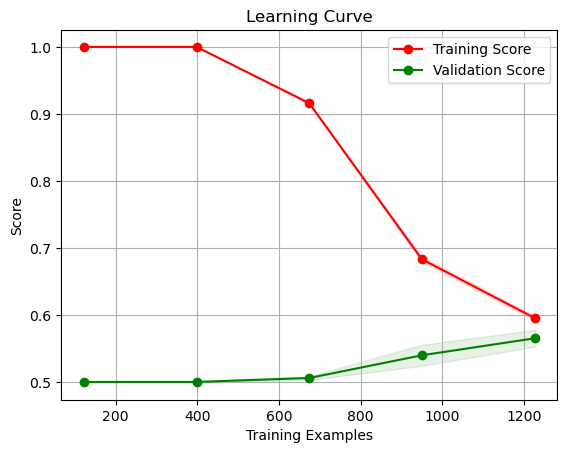

In [20]:
# plot training score vs. validation score

def plot_learning_curve(estimator, X, y, ylim=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, "o-", color = "r",
             label = "Training Score")
    plt.plot(train_sizes, test_scores_mean, "o-", color = "g",
             label = "Validation Score")

    plt.legend(loc = "best")
    
    return plt

plot_learning_curve(decision_tree_classifier, X, y)
plt.show()

array([[<Axes: title={'center': 'Accuracy'}, xlabel='age'>,
        <Axes: title={'center': 'False Positive Rate'}, xlabel='age'>,
        <Axes: title={'center': 'False Negative Rate'}, xlabel='age'>],
       [<Axes: title={'center': 'Selection Rate'}, xlabel='age'>,
        <Axes: title={'center': 'Count'}, xlabel='age'>,
        <Axes: xlabel='age'>],
       [<Axes: xlabel='age'>, <Axes: xlabel='age'>, <Axes: xlabel='age'>]],
      dtype=object)

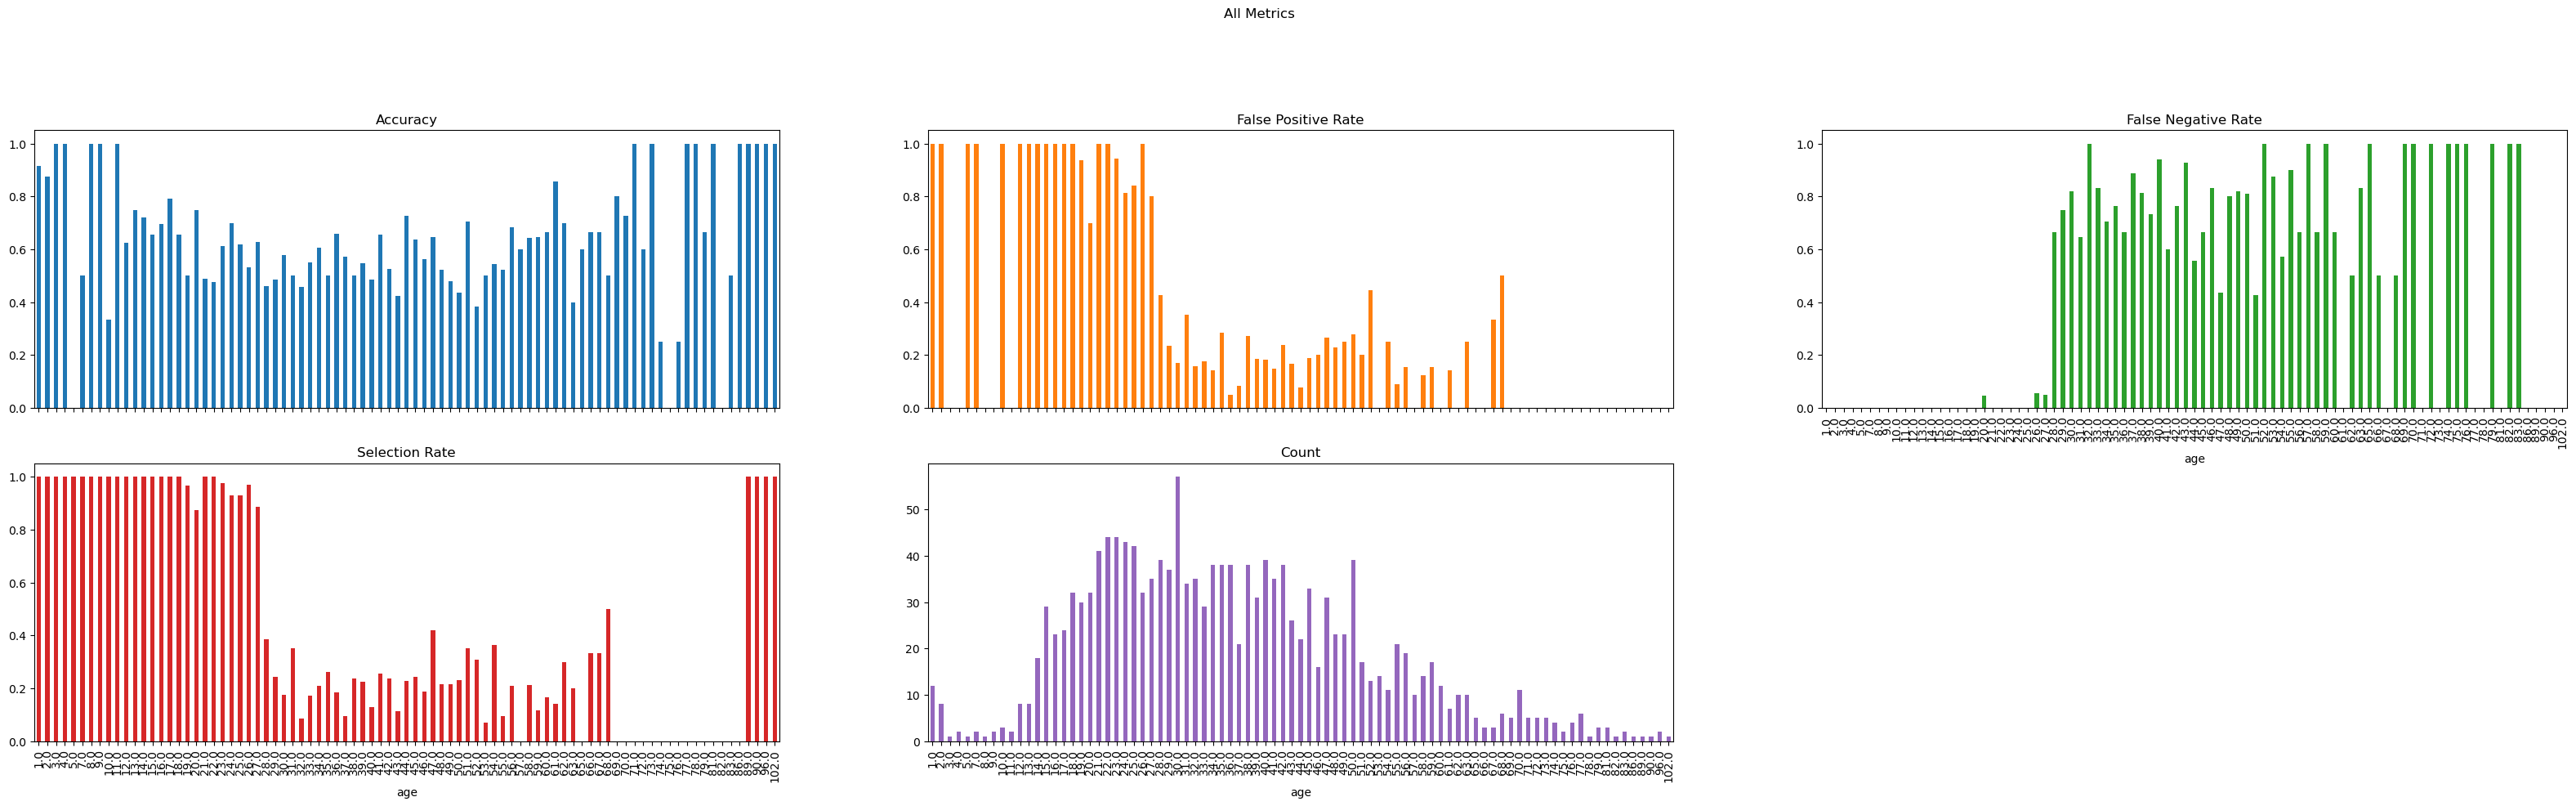

In [21]:
# assess fairness of demographics based on age

# there is noticeably more accuracy for young people and old people than the rest. young people have a higher
# false positive rate, and older people have a high false negative rate. data is very skewed for the false 
# positive rate and false negative rate, so there could be some bias there. however, some of these trends could
# be explained. more testing for covid-19 is directed toward vulnerable groups (young people and old people), so 
# it makes sense that these groups would have a higher accuracy

metric_frame = MetricFrame(
    metrics = metrics, y_true = y, y_pred = y_pred, sensitive_features = X["age"]
)

metric_frame.by_group.plot.bar(
    subplots = True,
    layout = [3, 3],
    legend = False,
    figsize = [40, 15],
    title = "All Metrics",
)

array([[<Axes: title={'center': 'Accuracy'}, xlabel='biological_sex_female'>,
        <Axes: title={'center': 'False Positive Rate'}, xlabel='biological_sex_female'>,
        <Axes: title={'center': 'False Negative Rate'}, xlabel='biological_sex_female'>],
       [<Axes: title={'center': 'Selection Rate'}, xlabel='biological_sex_female'>,
        <Axes: title={'center': 'Count'}, xlabel='biological_sex_female'>,
        <Axes: xlabel='biological_sex_female'>],
       [<Axes: xlabel='biological_sex_female'>,
        <Axes: xlabel='biological_sex_female'>,
        <Axes: xlabel='biological_sex_female'>]], dtype=object)

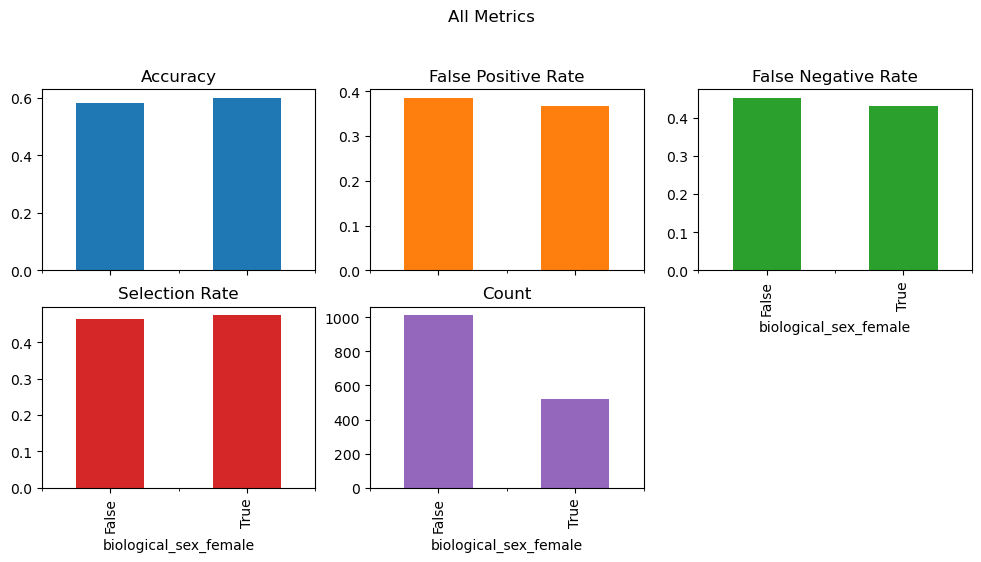

In [22]:
# assess fairness of demographics based on biological sex; only use the biological_sex_female column, as it has
# true or false for whether or not someone is biologically female (i.e. this accounts for biological males)

# thre are significantly more males than females, however, the data for females is more accurate and has a lower 
# false positive rate and false negative rate than males. it seems like there is little to no bias in terms of 
# biological sex

metric_frame = MetricFrame(
    metrics = metrics, y_true = y, y_pred = y_pred, sensitive_features = X["biological_sex_female"]
)

metric_frame.by_group.plot.bar(
    subplots = True,
    layout = [3, 3],
    legend = False,
    figsize = [12, 8],
    title = "All Metrics",
)

array([[<Axes: title={'center': 'Accuracy'}, xlabel='reported_gender_female'>,
        <Axes: title={'center': 'False Positive Rate'}, xlabel='reported_gender_female'>,
        <Axes: title={'center': 'False Negative Rate'}, xlabel='reported_gender_female'>],
       [<Axes: title={'center': 'Selection Rate'}, xlabel='reported_gender_female'>,
        <Axes: title={'center': 'Count'}, xlabel='reported_gender_female'>,
        <Axes: xlabel='reported_gender_female'>],
       [<Axes: xlabel='reported_gender_female'>,
        <Axes: xlabel='reported_gender_female'>,
        <Axes: xlabel='reported_gender_female'>]], dtype=object)

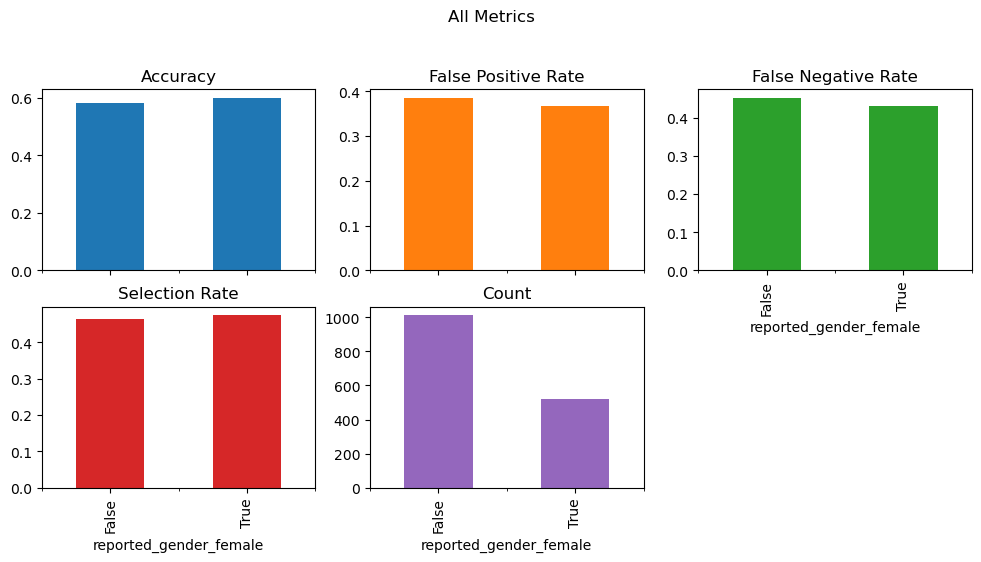

In [23]:
# assess fairness of demographics based on reported gender; only use the reported_gender_female column, as it has
# true or false for whether or not someone's reported gender is female (i.e. this accounts for people who reported 
# their gender as male)

# similar results to biological sex

metric_frame = MetricFrame(
    metrics = metrics, y_true = y, y_pred = y_pred, sensitive_features = X["reported_gender_female"]
)

metric_frame.by_group.plot.bar(
    subplots = True,
    layout = [3, 3],
    legend = False,
    figsize = [12, 8],
    title = "All Metrics",
)